In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from known.basic import Remap
from known import mod
from tqdm import tqdm
import torch as tt
import torch.nn as nn

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)

default_device = 'cuda' if tt.cuda.is_available() else 'cpu'
factory = dict(device=default_device, dtype=tt.float32)

import maco
import s2s

In [ ]:


def tenvF(): return maco.WorkersEnv.get(duration=15, n_workers=4, n_states=5, rng_seed=10293874756, scale=0.1, max_time_ratio=1.0)
def venvF(): return maco.WorkersEnv.get(duration=15, n_workers=4, n_states=5, rng_seed=10293874756, scale=0.1, max_time_ratio=1.0).freeze(0)
def venvsF(): return [ maco.WorkersEnv.get(duration=15, n_workers=4, n_states=5, rng_seed=10293874756, scale=0.1, max_time_ratio=1.0).freeze(f) for f in range(5)]

env = tenvF()
def pieF(**factory): 
    embed_dim = 32
    block_size = env.T
    num_heads = 4
    hidden_size=64
    activation2F = (nn.GELU, {})
    encoder_num_layers, decoder_num_layers = 2, 3
    dropout=0.0
    encoder_normF, decoder_normF = s2s.LayerNorm, s2s.LayerNorm
    norm_first=True
    score2F=( s2s.MHA.LearnableScoring, dict(
                                            embed_dim=embed_dim,
                                            block_size=block_size,
                                            num_heads=num_heads,
                                            scale=embed_dim**0.5,
                                            **factory) )
    #score2F = s2s.MHA.DotProdScoreing, dict(scale=embed_dim**0.5)
    return s2s.rl.S2SDQN(
    n_actions = env.A,

    custom_encoder=s2s.EncodingTransformer(
        embed_size=embed_dim,
        block_size=block_size,
        score2F_SA=score2F,
        vocab_size=env.task_vocab.count,
        pos_embed=s2s.TrainableLinearPE(
            input_size=embed_dim,
            block_size=block_size,
            **factory,
        ),
        num_heads=num_heads,
        hidden_size=hidden_size,
        activation2F=activation2F,
        num_layers=encoder_num_layers,
        dropout=dropout,
        normF=encoder_normF,
        norm_first=norm_first,
        cross_pre_norm=False,
        final_norm=False,
        attention_bias=True,
        ffn_bias=True,
        norm_bias=True,
        **factory
    ),
    custom_decoder=s2s.DecodingTransformer(
        embed_size=embed_dim,
        block_size=block_size,
        score2F_SA=score2F,
        score2F_CA=score2F,
        vocab_size=env.worker_vocab.count,
        pos_embed=s2s.TrainableLinearPE(
            input_size=embed_dim,
            block_size=block_size,
            **factory,
        ),
        num_heads=num_heads,
        hidden_size=hidden_size,
        activation2F=activation2F,
        num_layers=decoder_num_layers,
        dropout=dropout,
        normF=decoder_normF,
        norm_first=norm_first,
        cross_pre_norm=False,
        final_norm=False,
        attention_bias=True,
        ffn_bias=True,
        norm_bias=True,
        **factory
    ),
    dense_layer_dims=[64,64,64], 
    dense_actFs=[nn.Tanh(), nn.ReLU()], 
    dense_bias=True, 
    xavier_init=False, 
    has_target=True, 
    **factory
    )



In [ ]:
pie = pieF(**factory)
mod.count(pie.theta)

In [ ]:
tenv = tenvF()
venvs = venvsF()

In [ ]:
epochs = 100 
batch_size = 4
learn_times = 2
epsilon_range = (1.0, 0.1)

hist = s2s.rl.DQN.train(
        # value params [T.V]
            pie                 = pie,
            pie_optA            = dict(learning_rate=0.0001, weight_decay=0.00000000, betas=(0.99, 0.999)),
            value_lrsF          = tt.optim.lr_scheduler.LinearLR, 
            value_lrsA          = dict(start_factor=1.0, end_factor=0.1, total_iters=epochs),
        # env params (training) [E]
            env                 = tenv,
            gamma               = 1.0,
            polyak              = 0.0,
        # learning params [L]
            epochs              = epochs,
            batch_size          = batch_size,
            learn_times         = learn_times,
        # explore-exploit [X]
            explore_size        = batch_size*learn_times,
            explore_seed        = None,
            epsilon_range       = epsilon_range,
            epsilon_seed        = None, 
        # memory params [M]
            memory              = None,
            memory_capacity     = 50_000, 
            memory_seed         = None, 
            min_memory          = 1_000,
        # validation params [V]
            validations_envs    = venvs, 
            validation_freq     = int(0.05*epochs), 
            validation_max_steps= None,
            validation_episodes = 1,
            validation_verbose  = 0, 
        # algorithm-specific params [A]
            double              = False,
            tuf                 = 6,
            gradient_clipping   = 0.0,
        # result params [R]
            plot_results        = True,
            save_at             = 's2sDQN',
            checkpoint_freq     = int(0.1*epochs), 
            )

In [ ]:

s2s.rl.DQN.load_plot_training_result('s2sDQN/results.npz')

In [6]:
pie.load('s2sDQN/20.pie')

In [7]:
pie.theta.do_store_attention(True)

In [8]:
cr, t, acts = s2s.rl.Eval.test_policy(
    env=env,
    pie=pie,
)
cr, t, acts 

(-62.6, 15, [3, 3, 3, 3, 3, 3, 3, 1, 1, 3, 1, 3, 3, 3, 0])


 Decoder Layer 0

 Self_attention
(1, 15, 15) (15, 15)


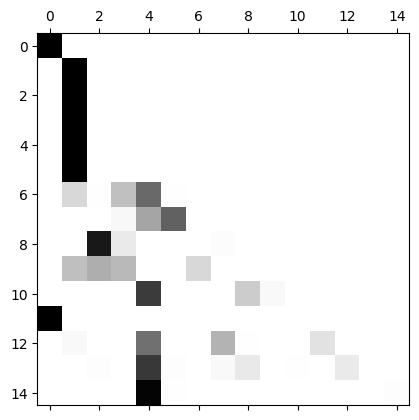

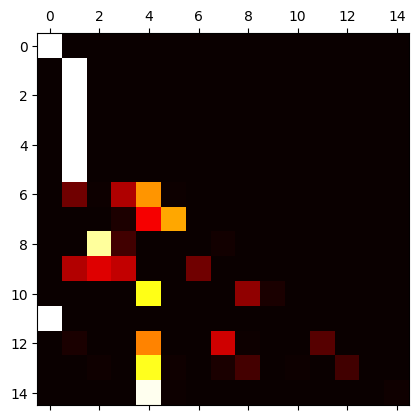


 Decoder Layer 1

 Self_attention
(1, 15, 15) (15, 15)


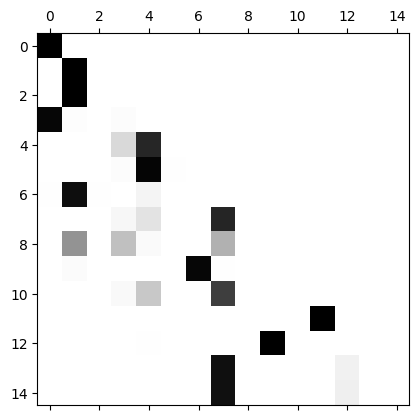

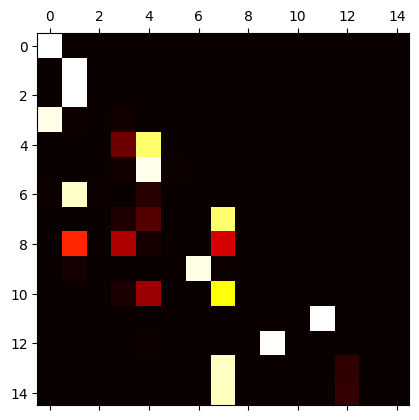


 Decoder Layer 2

 Self_attention
(1, 15, 15) (15, 15)


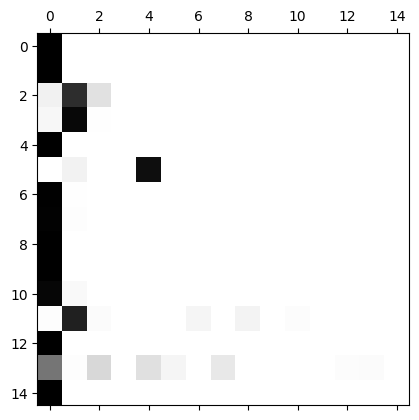

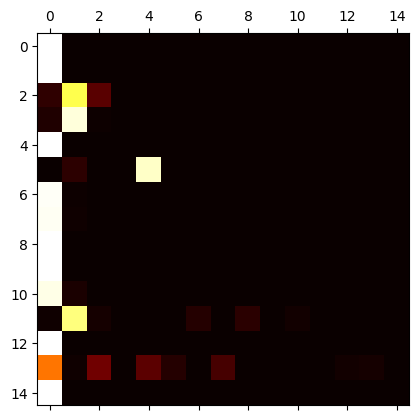

In [10]:
for j in range(len(pie.theta.decoder.coder)):
    print(f'\n Decoder Layer {j}')

    print(f'\n Self_attention')
    w = pie.theta.decoder.coder[j].self_attention.attention_weights.cpu().numpy()
    wa = np.mean(w, axis=0)
    print(w.shape, wa.shape)
    for i in range(len(w)):
        plt.matshow(w[i], vmin=0, vmax=1, cmap='binary')
        plt.show()
    plt.matshow(wa, vmin=0, vmax=1, cmap='hot')
    plt.show()





 Decoder Layer 0

 Cross attention
(1, 15, 15) (15, 15)


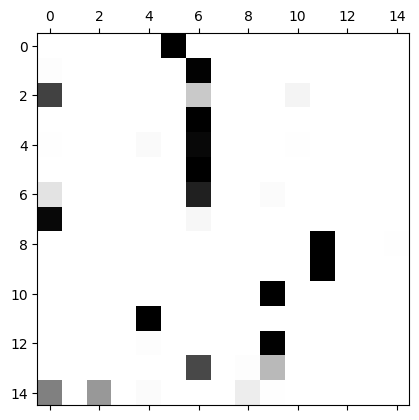

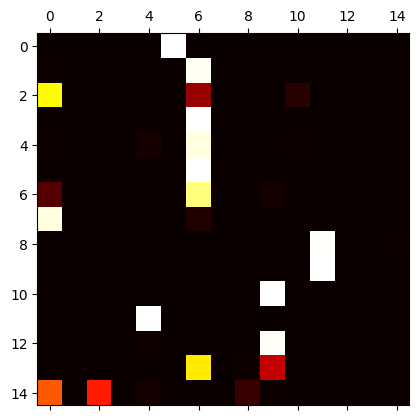


 Decoder Layer 1

 Cross attention
(1, 15, 15) (15, 15)


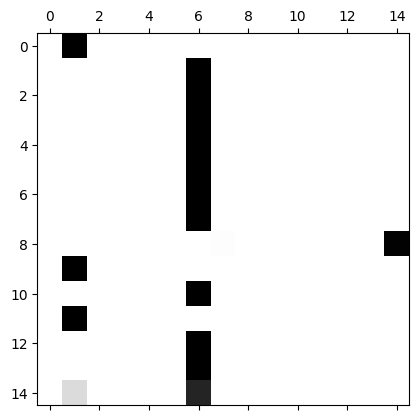

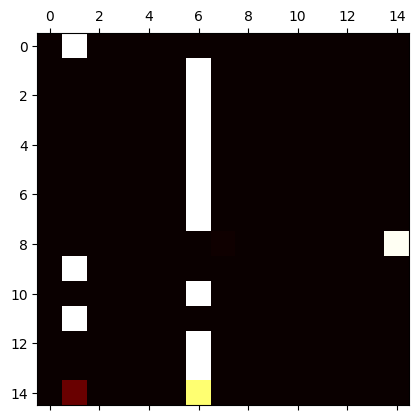


 Decoder Layer 2

 Cross attention
(1, 15, 15) (15, 15)


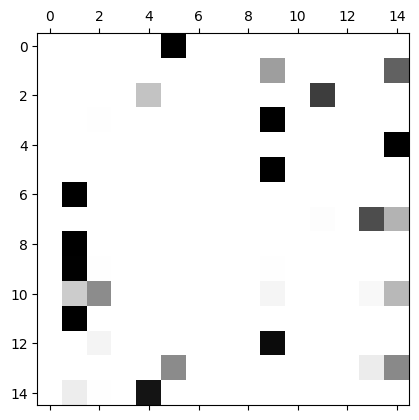

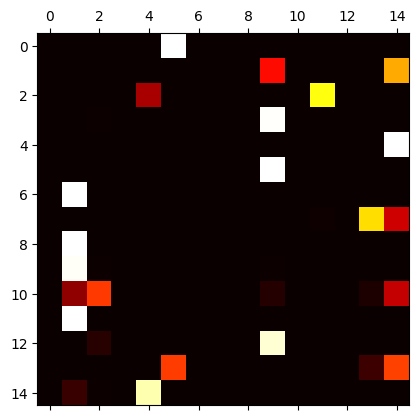

In [11]:
for j in range(len(pie.theta.decoder.coder)):
    print(f'\n Decoder Layer {j}')
    print(f'\n Cross attention')
    w = pie.theta.decoder.coder[j].cross_attention.attention_weights.cpu().numpy()
    wa = np.mean(w, axis=0)
    print(w.shape, wa.shape)
    for i in range(len(w)):
        plt.matshow(w[i], vmin=0, vmax=1, cmap='binary')
        plt.show()
    plt.matshow(wa, vmin=0, vmax=1, cmap='hot')
    plt.show()


 Encoder Layer 0

 Self attention
(1, 15, 15) (15, 15)


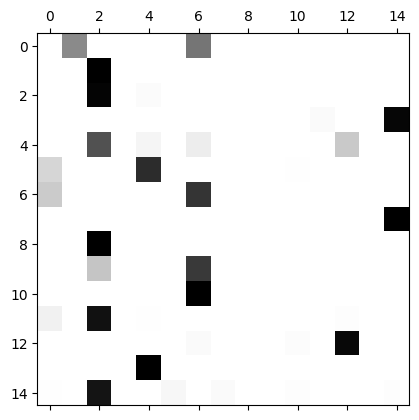

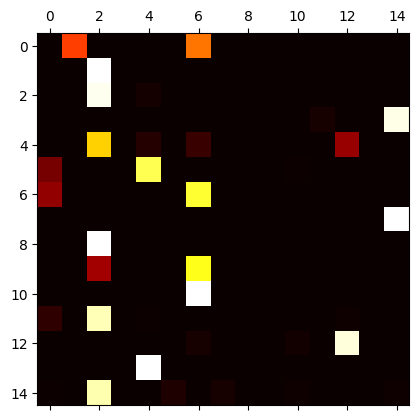


 Encoder Layer 1

 Self attention
(1, 15, 15) (15, 15)


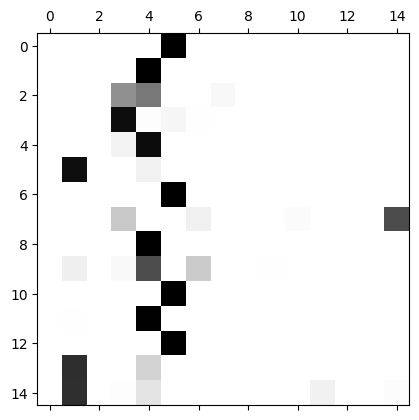

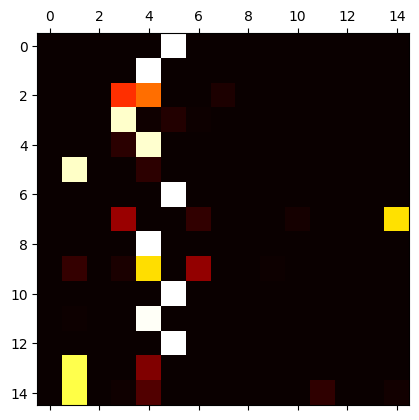

In [12]:
for j in range(len(pie.theta.encoder.coder)):
    print(f'\n Encoder Layer {j}')
    print(f'\n Self attention')
    w = pie.theta.encoder.coder[j].self_attention.attention_weights.cpu().numpy()
    wa = np.mean(w, axis=0)
    print(w.shape, wa.shape)
    for i in range(len(w)):
        plt.matshow(w[i], vmin=0, vmax=1, cmap='binary')
        plt.show()
    plt.matshow(wa, vmin=0, vmax=1, cmap='hot')
    plt.show()